In [ ]:
"""
Implementing PPO
First mistake I made -> ran the action using the policy, then calculated the ratio using old_policy. The correct way is to run the action using old_policy, then calculate the ratio using the new policy.
Second mistake -> didn't run K epochs while calculating the surrogate objective.
Then, it started behaving like a trained model, though did not achieve goal.
Another fix. Added minibatching according to the original paper.
Minibatching made the training significantly slower due to more frequent optimizer steps.
Experimented both GAE and decaying returns. Both did not show good results. Will try debugging in Cartpole.
Tried using single environment and no minibatching like the reference model -> didn't work.
Switched to time step based update instead of episode based updates -> didn't work.
Went back to decaying returns -> didn't work.
Found dimension bugs when calculating returns -> didn't fix.
Debugged by resetting decaying reward in terminated states 0> fixed!
"""

"\nImplementing PPO\nFirst mistake I made -> ran the action using the policy, then calculated the ratio using old_policy. The correct way is to run the action using old_policy, then calculate the ratio using the new policy.\nSecond mistake -> didn't run K epochs while calculating the surrogate objective.\nThen, it started behaving like a trained model, though did not achieve goal.\nAnother fix. Added minibatching according to the original paper.\nMinibatching made the training significantly slower due to more frequent optimizer steps.\nExperimented both GAE and decaying returns. Both did not show good results. Will try debugging in Cartpole.\nTried using single environment and no minibatching like the reference model.\n"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!pip install gymnasium
!pip install pygame
!pip install wheel setuptools
!pip install swig
!pip install gymnasium[box2d]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 9.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp311-cp311-linux_x86_64.whl size=2379411 sha256=d30a5006450017a28122224a5662ca7239a42ad028d781c899f3b40a3c3a5cf1
  Stored in directory: /root/.cache/pip/wheels/ab/f1/0c/d56f4a2bdd12bae0a0693ec33f2f0daadb5eb9753c78fa5308
Successfully built box2d-py


In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class ActorCriticPPO(nn.Module):

    def __init__(self, input_dim, output_dim, hidden_dims=(64, 64)):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dims[0]),
            nn.ReLU()
        )
        self.actor_layer = nn.Sequential(
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(),
            nn.Linear(hidden_dims[1], output_dim)
        )
        self.critic_layer = nn.Sequential(
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(),
            nn.Linear(hidden_dims[1], 1)
        )

    def forward(self, x):
        x = self.net(x)
        action_probs = F.softmax(self.actor_layer(x), dim=-1)
        value = self.critic_layer(x)
        return action_probs, value


In [3]:
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
import numpy as np
import copy
from datetime import datetime
import gymnasium as gym
import matplotlib.pyplot as plt


# class RolloutBuffer to store variables during training
class RolloutBuffer:
    def __init__(self):
        self.states = []
        self.actions = []
        self.rewards = []
        self.next_states = []
        self.logprobs = []
        self.values = []
        self.is_dones = []

    def clear(self):
        self.__init__()


class PPOAgent:
    def __init__(self, env_id, total_timesteps=1e5, max_steps=500, epsilon=float('inf'), gamma=0.99, lambda_GAE=0.95,
                 lr=1e-3, num_steps=0, num_envs=8, num_epochs=4, minibatch_size=4, vectorization_mode="sync", seed=123, is_GAE=False,
                 plot=True, plot_params = [True, False, False, False]):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # using vectorized environments to boost training speed
        if num_envs == 1:
            self.env = gym.make(env_id)
            self.policy_net = ActorCriticPPO(self.env.observation_space.shape[0], self.env.action_space.n).to(self.device)
        else:
            self.env = gym.make_vec(env_id, num_envs=num_envs, vectorization_mode=vectorization_mode)
            self.policy_net = ActorCriticPPO(self.env.single_observation_space.shape[0], self.env.single_action_space.n).to(self.device)
        self.num_envs = num_envs
        self.total_timesteps = total_timesteps
        self.num_epochs = num_epochs
        self.max_steps = max_steps
        self.minibatch_size = minibatch_size
        self.epsilon = epsilon
        self.gamma = gamma
        self.lambda_GAE = lambda_GAE
        self.lr = lr
        self.num_steps = num_steps
        self.old_policy_net = copy.deepcopy(self.policy_net)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.lr)
        # added scheduler after observing divergence after getting close to solving
        self.scheduler = StepLR(self.optimizer, step_size=500 * num_epochs, gamma=0.9)
        self.critic_loss = nn.MSELoss()
        self.seed = seed
        self.buffer = RolloutBuffer()
        self.is_GAE = is_GAE
        self.plot = plot
        self.plot_params = plot_params

    # choosing action from policy's probability distribution
    def choose_action(self, state):
        with torch.no_grad():
            probs, value = self.old_policy_net(state)
            action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        log_prob = action_dist.log_prob(action)
        return action, log_prob, value

    # compute the advantages
    def compute_advantages(self, rewards, values, next_value, is_dones):
        if self.num_envs == 1:
            T = rewards.shape[0]
            N = 1
        else:
            T, N = rewards.shape
        returns = torch.zeros_like(rewards)
        R = torch.zeros(N, device=rewards.device)

        for t in reversed(range(T)):
            # forgetting to mask terminal states led R to build up forever.
            R = rewards[t] + self.gamma * R * (1 - is_dones[t])
            returns[t] = R

        # normalize discounted_rewards across all timesteps and environments
        returns = (returns - returns.mean()) / (returns.std() + 1e-8)
        advantages = returns - values.squeeze()
        return returns, advantages


    # compute the GAE
    def compute_GAE(self, rewards, values, next_value, is_dones):
        if self.num_envs == 1:
            T = rewards.shape[0]
            N = 1
        else:
            T, N = rewards.shape
        advantages = torch.zeros_like(rewards)
        td = torch.zeros(N, device=rewards.device)
        gae = torch.zeros(N, device=rewards.device)
        values = torch.cat([values, next_value.unsqueeze(0)], dim=0)

        for t in reversed(range(T)):
            # temporal difference error
            td = rewards[t] + self.gamma * values[t + 1] * (1 - is_dones[t]) - values[t]
            # higher labmda -> more sampling, lower lambda -> more bootstrapping
            gae = td + self.gamma * self.lambda_GAE * (1 - is_dones[t]) * gae
            advantages[t] = gae

        # compute returns by adding value to advantage
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
        returns = advantages + values[:-1]

        return returns, advantages


    def update(self):
        # retrieve info from buffer
        old_states      = torch.stack(self.buffer.states)
        old_actions     = torch.stack(self.buffer.actions)
        old_rewards     = torch.stack(self.buffer.rewards)
        old_next_states = torch.stack(self.buffer.next_states)
        old_log_probs   = torch.stack(self.buffer.logprobs)
        old_values      = torch.stack(self.buffer.values)
        is_dones        = torch.stack(self.buffer.is_dones)
        _, next_value = self.old_policy_net(old_next_states[-1])
        next_value = next_value.squeeze(-1)

        if self.is_GAE:
            with torch.no_grad():
                old_returns, old_advantages = self.compute_GAE(old_rewards, old_values, next_value, is_dones)
                old_returns = old_returns.detach()
                old_advantages = old_advantages.detach()
        else:
            old_returns, old_advantages = self.compute_advantages(old_rewards, old_values, next_value, is_dones)

        batch_size = old_states.shape[0]
        minibatch_size = self.minibatch_size

        for _ in range(self.num_epochs):
            action_probs, values = self.policy_net(old_states)
            action_dist = torch.distributions.Categorical(action_probs)
            log_probs = action_dist.log_prob(old_actions)
            prob_ratios = torch.exp(log_probs - old_log_probs.detach())
            values = values.squeeze(-1)

            surrogate = torch.min(
                prob_ratios * old_advantages,
                prob_ratios.clamp(1 - self.epsilon, 1 + self.epsilon) * old_advantages
            )

            actor_loss = -surrogate.mean()
            critic_loss = self.critic_loss(old_returns, values)
            entropy = action_dist.entropy().mean()
            loss = actor_loss + 0.5 * critic_loss - 0.01 * entropy

            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()
        # self.scheduler.step()

        return actor_loss, critic_loss, entropy


    def train(self):
        episode_rewards = episode_rewards = [[] for _ in range(self.num_envs)]
        episode_nums = [0] * self.num_envs
        steps = 0
        start_time = datetime.now().replace(microsecond=0)
        actor_losses = []
        critic_losses = []
        entropies = []
        mean_rewards = []

        state, _ = self.env.reset()
        episode_reward = np.zeros(self.num_envs)


        while steps < self.total_timesteps:
            steps += 1
            state_tensor = torch.tensor(state, dtype=torch.float32).to(self.device)

            action, log_prob, value = self.choose_action(state_tensor)
            value = value.squeeze(-1)
            next_state, reward, terminated, truncated, _ = self.env.step(action.cpu().numpy())
            episode_reward += reward
            next_state_tensor = torch.tensor(next_state, dtype=torch.float32).to(self.device)
            done = np.logical_or(terminated, truncated)

            self.buffer.states.append(state_tensor)
            self.buffer.actions.append(action.clone().detach())
            self.buffer.logprobs.append(log_prob.clone().detach())
            self.buffer.next_states.append(next_state_tensor)
            self.buffer.rewards.append(torch.tensor(reward, dtype=torch.float32).to(self.device))
            self.buffer.is_dones.append(torch.tensor(done, dtype=torch.float32).to(self.device))
            self.buffer.values.append(value.clone().detach())

            for i in np.where(done)[0]:
                episode_rewards[i].append(episode_reward[i])
                episode_nums[i] += 1
                episode_reward[i] = 0

            state = next_state

            # updating the policy net
            if steps % self.num_steps == 0:
                actor_loss, critic_loss, entropy = self.update()
                self.buffer.clear()
                self.old_policy_net = copy.deepcopy(self.policy_net)

                # log values for plotting
                actor_losses.append(actor_loss.item())
                critic_losses.append(critic_loss.item())
                entropies.append(entropy.item())

            # Log every batch of self.num_steps * 10 timesteps
            if steps % (self.num_steps * 10) == 0:
                print(f"\n[Timesteps: {steps}, Min Episode: {min(episode_nums)}]")
                print([len(rewards) for rewards in episode_rewards])
                recent_rewards = [rewards[-1] for rewards in episode_rewards]
                avg_last_10 = [np.mean(rewards[-10:]) if len(rewards) >= 10 else np.mean(rewards) for rewards in episode_rewards]
                print(f"Reward (mean over envs): {np.mean(recent_rewards):.2f} | Avg Reward (last 10): {np.mean(avg_last_10):.2f}")
                print(f"Actor_loss (mean over envs): {actor_loss:.2f} | Critic_loss (mean over envs): {critic_loss:.2f}")
                print(f"Training time: {(datetime.now().replace(microsecond=0) - start_time)}")

        self.env.close()
        if self.plot:
            self.plot_training_curves(episode_rewards, actor_losses, critic_losses, entropies, self.plot_params)

        return episode_rewards

    def plot_training_curves(self, episode_rewards, actor_losses, critic_losses, entropies, plot_params):
        plt.figure(figsize=(14, 10))

        if plot_params[0]:
            plt.subplot(2, 2, 4)
            min_episode = min([len(rewards) for rewards in episode_rewards])
            plt.plot([np.mean([rewards[i] for rewards in episode_rewards]) for i in range(min_episode)], label='Mean Reward per Update', color='red')
            plt.xlabel('Update')
            plt.ylabel('Reward')
            plt.title('Mean Reward Over Time')
            plt.grid(True)

        if plot_params[1]:
            plt.subplot(2, 2, 1)
            plt.plot(actor_losses, label='Actor Loss')
            plt.xlabel('Update')
            plt.ylabel('Loss')
            plt.title('Actor Loss Over Time')
            plt.grid(True)

        if plot_params[2]:
            plt.subplot(2, 2, 2)
            plt.plot(critic_losses, label='Critic Loss', color='orange')
            plt.xlabel('Update')
            plt.ylabel('Loss')
            plt.title('Critic Loss Over Time')
            plt.grid(True)

        if plot_params[3]:
            plt.subplot(2, 2, 3)
            plt.plot(entropies, label='Entropy', color='green')
            plt.xlabel('Update')
            plt.ylabel('Entropy')
            plt.title('Entropy Over Time')
            plt.grid(True)

        plt.tight_layout()
        plt.show()


[Timesteps: 5120, Min Episode: 46]
[57, 46, 57, 56]
Reward (mean over envs): -165.89 | Avg Reward (last 10): -145.85
Actor_loss (mean over envs): 0.03 | Critic_loss (mean over envs): 0.85
Training time: 0:00:10

[Timesteps: 10240, Min Episode: 101]
[103, 101, 111, 101]
Reward (mean over envs): -94.69 | Avg Reward (last 10): -109.23
Actor_loss (mean over envs): -0.07 | Critic_loss (mean over envs): 0.74
Training time: 0:00:20

[Timesteps: 15360, Min Episode: 144]
[149, 147, 154, 144]
Reward (mean over envs): -29.14 | Avg Reward (last 10): -71.93
Actor_loss (mean over envs): 0.09 | Critic_loss (mean over envs): 0.57
Training time: 0:00:30

[Timesteps: 20480, Min Episode: 168]
[177, 176, 185, 168]
Reward (mean over envs): -51.68 | Avg Reward (last 10): -46.97
Actor_loss (mean over envs): 0.42 | Critic_loss (mean over envs): 0.71
Training time: 0:00:40

[Timesteps: 25600, Min Episode: 186]
[191, 198, 201, 186]
Reward (mean over envs): 10.79 | Avg Reward (last 10): -23.15
Actor_loss (mean 

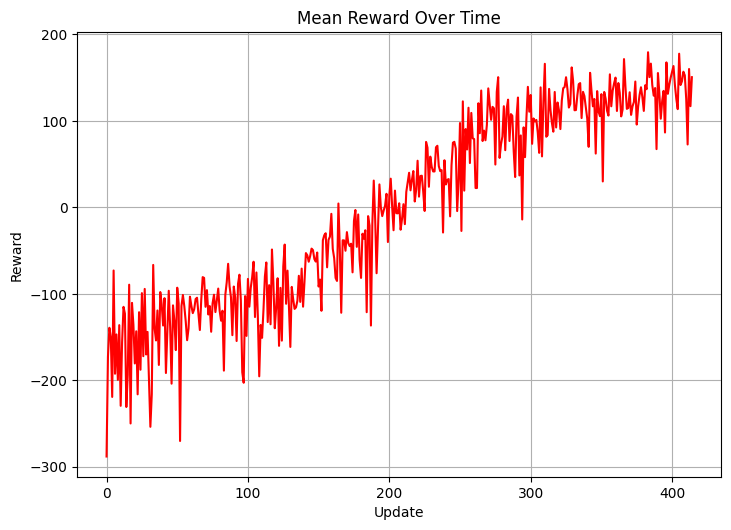

In [7]:
import gymnasium as gym

env_id = 'LunarLander-v3'
max_steps = 1000
lr = 3e-4


ppo_model =  PPOAgent(env_id, max_steps=max_steps, total_timesteps=2e5, lr=lr, epsilon=0.2, num_envs=4, num_steps=512, num_epochs=20, minibatch_size=16)

rewards = ppo_model.train()


[Timesteps: 5120, Min Episode: 46]
[52, 50, 46, 50]
Reward (mean over envs): -152.02 | Avg Reward (last 10): -168.26
Actor_loss (mean over envs): -0.01 | Critic_loss (mean over envs): 0.80
Training time: 0:00:11

[Timesteps: 10240, Min Episode: 88]
[93, 95, 88, 93]
Reward (mean over envs): -242.45 | Avg Reward (last 10): -160.67
Actor_loss (mean over envs): -0.01 | Critic_loss (mean over envs): 0.53
Training time: 0:00:21

[Timesteps: 15360, Min Episode: 121]
[124, 130, 121, 129]
Reward (mean over envs): -129.82 | Avg Reward (last 10): -180.97
Actor_loss (mean over envs): -0.00 | Critic_loss (mean over envs): 0.48
Training time: 0:00:32

[Timesteps: 20480, Min Episode: 146]
[146, 158, 146, 160]
Reward (mean over envs): -120.41 | Avg Reward (last 10): -143.92
Actor_loss (mean over envs): -0.00 | Critic_loss (mean over envs): 0.61
Training time: 0:00:42

[Timesteps: 25600, Min Episode: 162]
[162, 170, 165, 179]
Reward (mean over envs): -63.51 | Avg Reward (last 10): -79.64
Actor_loss (m

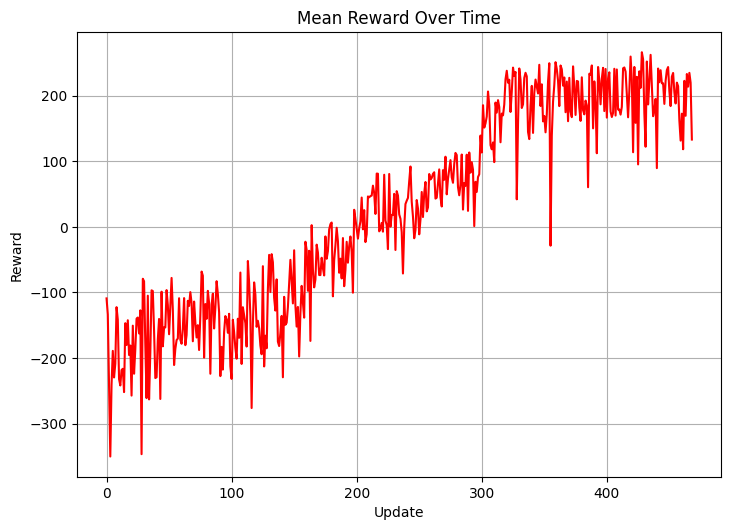

In [5]:
import gymnasium as gym

env_id = 'LunarLander-v3'
max_steps = 1000
lr = 2e-4


ppo_model_GAE =  PPOAgent(env_id, max_steps=max_steps, total_timesteps=2e5, lr=lr, epsilon=0.1, num_envs=4, num_steps=512, num_epochs=20, minibatch_size=16, is_GAE=True)

rewards_GAE = ppo_model_GAE.train()

In [10]:
import gymnasium as gym
import torch
import numpy as np
from gymnasium.wrappers import RecordVideo
import os

# Create folder to save the video
video_folder = "./video"
os.makedirs(video_folder, exist_ok=True)

# Wrap the environment with RecordVideo
env = gym.make(env_id, render_mode='rgb_array')
env = RecordVideo(env, video_folder=video_folder, episode_trigger=lambda e: True, name_prefix=env_id)

num_episodes = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

episode_rewards = []

for i in range(num_episodes):
    state, _ = env.reset()
    state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
    episode_reward = 0
    done = False

    while not done:
        with torch.no_grad():
            action_probs, _ = ppo_model.policy_net(state)
            # action_dist = torch.distributions.Categorical(action_probs)
            # action = action_dist.sample().item()
            action = torch.argmax(action_probs, dim=1).item()

        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        episode_reward += reward

        state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0).to(device)

    episode_rewards.append(episode_reward)
    print(f"Episode {i+1} Reward: {episode_reward}")

env.close()

episode_rewards = np.array(episode_rewards)
print(f"Average Reward over {num_episodes} episodes: {np.mean(episode_rewards)}")


/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /content/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Episode 1 Reward: 217.46620888309758
Episode 2 Reward: 142.5415749872046
Episode 3 Reward: 53.75556511900558
Episode 4 Reward: 149.42756314377164
Episode 5 Reward: -54.144190641451274
Episode 6 Reward: 219.89693728020296
Episode 7 Reward: 252.27911161279732
Episode 8 Reward: 230.15269852882577
Episode 9 Reward: 247.94039069506098
Episode 10 Reward: 246.9947837958654
Average Reward over 10 episodes: 170.6310643404381


In [11]:
import gymnasium as gym
import torch
import numpy as np
from gymnasium.wrappers import RecordVideo
import os

# Create folder to save the video
video_folder = "./video"
os.makedirs(video_folder, exist_ok=True)

# Wrap the environment with RecordVideo
env = gym.make(env_id, render_mode='rgb_array')
env = RecordVideo(env, video_folder=video_folder, episode_trigger=lambda e: True, name_prefix=env_id + "-GAE")

num_episodes = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

episode_rewards = []

for i in range(num_episodes):
    state, _ = env.reset()
    state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
    episode_reward = 0
    done = False

    while not done:
        with torch.no_grad():
            action_probs, _ = ppo_model_GAE.policy_net(state)
            # action_dist = torch.distributions.Categorical(action_probs)
            # action = action_dist.sample().item()
            action = torch.argmax(action_probs, dim=1).item()

        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        episode_reward += reward

        state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0).to(device)

    episode_rewards.append(episode_reward)
    print(f"Episode {i+1} Reward: {episode_reward}")

env.close()

episode_rewards = np.array(episode_rewards)
print(f"Average Reward over {num_episodes} episodes: {np.mean(episode_rewards)}")


Episode 1 Reward: 246.54859911255397
Episode 2 Reward: 208.99889170336223
Episode 3 Reward: -54.18953114621388
Episode 4 Reward: -70.7858202827711
Episode 5 Reward: 239.60767144573788
Episode 6 Reward: 11.826487745937314
Episode 7 Reward: 174.55958980634654
Episode 8 Reward: 201.2575558795097
Episode 9 Reward: 212.46673424232142
Episode 10 Reward: 208.29546153024316
Average Reward over 10 episodes: 137.85856400370272
